# Predicting Demand for Bikeshare Service

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

# Introduction

Here I will walk through my steps from the initial loading of the data to my final conclusions of the analysis. First I will load in the data itself:

In [2]:
# load
bikeshare_df = pd.read_csv('data/bike_share.csv')

# shape and head
print(bikeshare_df.head())
print()
print(f'Shape: {bikeshare_df.shape}')

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  

Shape: (17379, 17)


This gives us an idea of how big the data set is, and what each column is. Straight from the UCI Machine Learning Repository, here are the descriptions of the columns:
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

We have 17379 instances of this data. There is an instance for each hour of data for two years.

# Theory and Seasonality

 This is considered time series data, since there is a new data point for each point in time. In general, you can think of time series data as being composed of three components: seasonal, trend, and residual (random). These components can be further divided, as in the case where there are multiple seasonalities or trends going on simultaneously.

In this project, I am not interested in the long term trend of this data. Instead, I will focus on the seaonal and random aspects of it. The goal is to be able to predict what factors about a particular hour of the day relate to the usage of bicycle rentals. Assuming your business is fairly steady and you have a general idea of how large your base is, this should tell you *when* you expect to be busier or not. I am not trying to predict how this business will grow over the next year or so - I don't believe to have sufficient data for that. But instead, I am trying to predict the relative amount of business it will get on 2 p.m. next Thursday, for example.

Given that, I will need to correct for the effects of long term trends of the data. If I don't, it will surely skew the results when testing it on new data. Let's look at the data to see if we can identify any long-term trends:

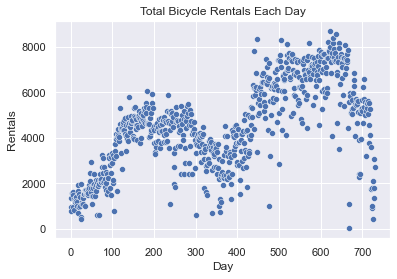

In [3]:
# total usage per day
sns.set(rc = {'figure.figsize':(8,5)})
count_by_day = bikeshare_df.groupby(by='dteday')['cnt']
daily_count_sum = count_by_day.sum().values
sns.scatterplot(data=daily_count_sum)
plt.title('Total Bicycle Rentals Each Day')
plt.xlabel('Day')
plt.ylabel('Rentals')
plt.show()

Here we have the plot for the total number of bicycles rented each **day** for every day in the data set. We can see a seasonal pattern, and also that one year is higher in general than the last. The latter is what we want to correct for. We don't know what's causing this, and for the most part we don't care. It is likely something not captured in the data.

We have to make an assumption about the data to correct for the trend. Going back to the topic of modeling seasonal data, there is a common strategy to assume your data takes the form:

$$y(t) = T(t)*S(t)$$ 

Where $y(t)$ is the target variable (bicycle rentals), $T(t)$ is the long term trend component, $S(t)$ is the seasonal and random comonents, and $t$ is time. Usually there is a third term on the right-hand side of the equation which separates the seasonal and random components, but I have decided to group them since I really only want to separate out the long-term trend component.

Since I am looking for $S(t)$, I can rewrite the above as

$$S(t) = \frac{y(t)}{T(t)}$$

In other words, I can divide each data point by the trend component to get the resulting component. The most simple way to get the trend component is to assume its form is linear, and then solve for it. This is as simple as doing a linear regression on the data set and dividing each point by its projection onto that line. As long as the line begins and ends on the same point of the season, this should be ok. We can assume it does since it begins and ends on the same day of the year. Here is what our data looks like with a trend line through it:

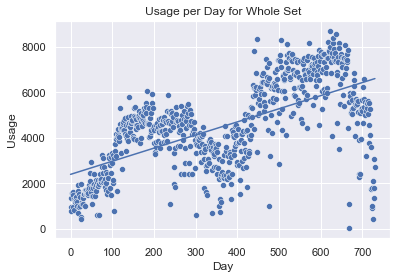

In [4]:
# regression
x = np.linspace(1, len(daily_count_sum), len(daily_count_sum)).reshape(-1,1)
y = daily_count_sum
reg = LinearRegression()
reg.fit(x,y)
reg_line = reg.predict(x)

# plots
sns.scatterplot(data=daily_count_sum)
sns.lineplot(data=reg_line)
plt.title('Usage per Day for Whole Set')
plt.xlabel('Day')
plt.ylabel('Usage')
plt.show()

And now with the trend line removed:

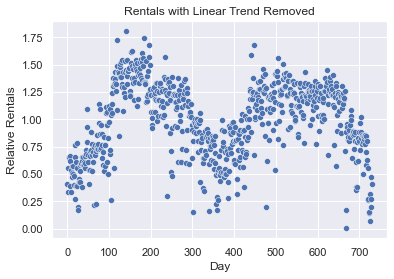

In [5]:
#corrected_count
corrected_count = daily_count_sum / reg_line
sns.scatterplot(data=corrected_count)
plt.title('Rentals with Linear Trend Removed')
plt.xlabel('Day')
plt.ylabel('Relative Rentals')
plt.show()

Note that the units on the y-axis have changed. Instead of an absolute number of bicycle rentals, they are a number that represents the relative amount of rentals that can be compared across days. This quantity preserves two things I want it to preserve:
   - 0 bike rentals translates to 0 of this quantity
   - A multiple amount of bike rentals on a given day translates to a multiple of this quantity

The last thing I will note about this is that this method may be prone to overcorrecting in one year and overcorrecting in another. If the trend component is not actually linear, this will almost inevitably happen. My intention was not to perfectly separate out the correct trend, but instead to make a reasonable assumption that makes our data better.

# Data Preparation

The target variable of the dataset is based on the variable 'cnt', which represents the number of bicycle rentals in each hour of the dataset. I will have to adjust that variable based on my reasoning above. Let's do that first and and name the result 'new_count'.

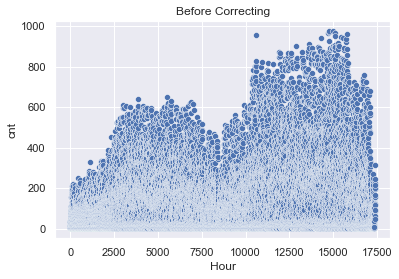

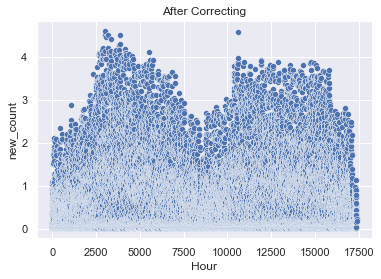

In [6]:
# regression
count = bikeshare_df['cnt']
x = np.linspace(1, len(count), len(count)).reshape(-1,1)
y = count
reg = LinearRegression()
reg.fit(x,y)
reg_line = reg.predict(x)

# correct
bikeshare_df['new_count'] = count / reg_line

# more plots
sns.scatterplot(data=bikeshare_df['cnt'])
plt.title('Before Correcting')
plt.xlabel('Hour')
plt.show()

# after correction
sns.scatterplot(data=bikeshare_df['new_count'])
plt.title('After Correcting')
plt.xlabel('Hour')
plt.show()

This looks better, and very similar to the other plots above. My last change will be to rescale the data so it fits between 0 and 1. This won't change the relationship to eachother, but it might make it easier to interpret. You can think of the value of each datapoint as a multiple of the busiest hour on record.

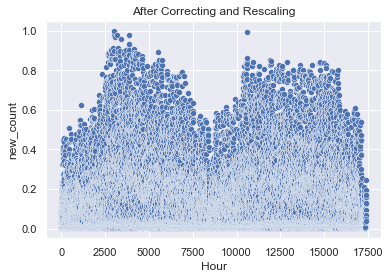

In [7]:
# scale
bikeshare_df['new_count'] = bikeshare_df['new_count'] / max(bikeshare_df['new_count'])

# replot
sns.scatterplot(data=bikeshare_df['new_count'])
plt.title('After Correcting and Rescaling')
plt.xlabel('Hour')
plt.show()

Now that we have our target variable, we can choose which features to include in the model. We can start by including all that can be used to predict our target variable. It might be easier to describe which can be excluded. We want to exclude 'casual' and 'registered', since they are subsets of the target variable and unable to be used for prediction. We want to exclude 'yr', since we don't want to measure effects that depend on the year we are in (long-term trends). Remember, we have already corrected for that. Additionally, there is 'instant', which doesn't contain any useful information. We also have 'dteday', which is the date. We can convert that to the day of the year, which ranges from 1-365 (366 for leap years).

In [8]:
# convert to day of year
def to_jday(date): # function
    ts = pd.Timestamp(date)
    tt = ts.timetuple()
    jday = tt.tm_yday
    return jday

# apply
bikeshare_df['jday'] = bikeshare_df['dteday'].apply(to_jday)

We now have all the features we need. We can put that in a list for later use.

In [9]:
# feature columns
features = ['mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'season',
            'jday']

# Modeling

Now that we have our features and target variable, we can start to put it into a model. We will need a regression model since we are predicting a continuous variable. We also need a model that can handle complex, non-linear relationships. The most simple model of this sort is a decision tree. To prevent overlearning, we can use the ensemble of decision trees called random forest regression. Let's plug it all in and see how it performs.

In [10]:
# x, y
X = bikeshare_df[features]
y = bikeshare_df['new_count']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# decision tree
reg = RandomForestRegressor(max_depth=None)
reg.fit(X_train, y_train)

# R Squared Metric
print(reg.score(X_test, y_test))

# estimatiors
d_tree = reg.estimators_[14]

0.9381462548967758


Using random forest regression gets us a very good coeficient of determination of ~0.93.

DecisionTreeRegressor(max_features=1.0, random_state=1706576506)


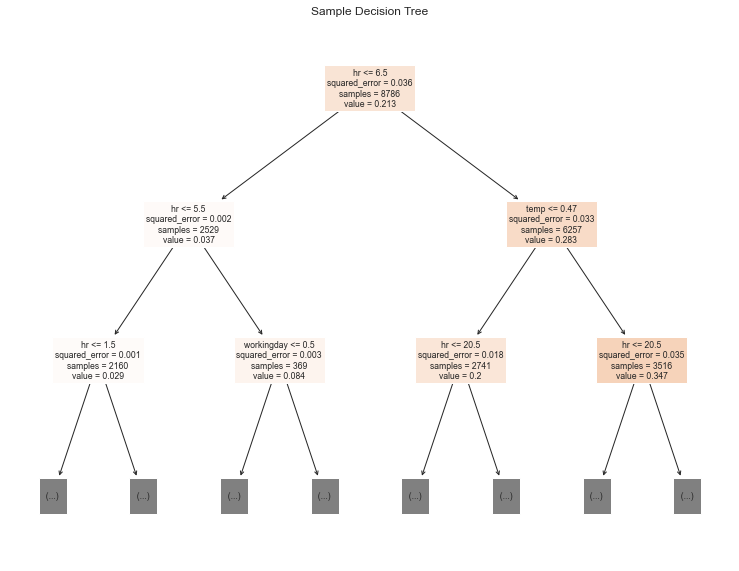

In [11]:
#  show decision tree
print(d_tree)
sns.set(rc = {'figure.figsize':(13,10)})
plot_tree(d_tree, max_depth=2, feature_names=features, filled=True)
plt.title('Sample Decision Tree')
plt.show()

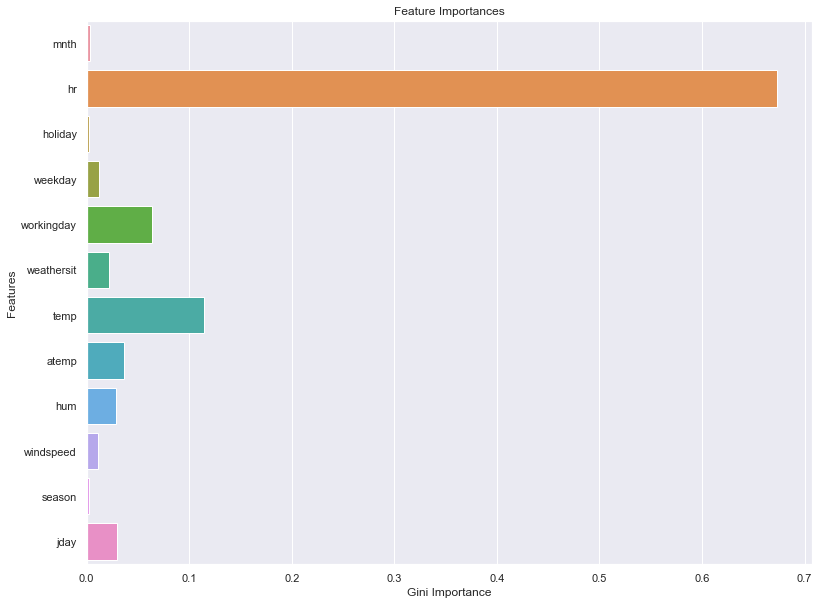

In [13]:
# show feature importances
importances = reg.feature_importances_

# plot
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.ylabel('Features')
plt.xlabel('Gini Importance')
plt.show()